<a href="https://colab.research.google.com/github/kr7/seizure/blob/main/SeizureDetection_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Enhanced ROCKET for Automated Detection of Epileptic Tonic-Clonic Seizure Using Accelerometer Data**

This notebook contains the implementation of the baselines (MLP, CNN, FCN and ResNet) used in the above paper.

In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from numpy import random as rnd
from scipy.io import arff
from scipy.stats import ttest_rel
from sklearn.model_selection import StratifiedKFold

**Experimental Settings**

In [ ]:
device = "cuda" # may be set to "cpu" if calculations are not expected to be performed on GPU
backbone = "FCN" # may be set to MLP, CNN, FCN or ResNet
epochs = 1000 # 100 for OpenSeizure data
LR = 1e-5 # 1e-4 for OpenSeizure data
batchsize = 16 # 32 for OpenSeizure data

dataset = "Epilepsy"
# dataset may be set to "Epilepsy" or "OpenSeizure"
# - "Epilepsy" denotes the dataset that is publicly available from
#   https://timeseriesclassification.com/aeon-toolkit/Epilepsy.zip
# - If you want to use the "OpenSeizure" data, you should first execute
#   the script to preprocess data. This notebook will ask you to upload
#   the preprocessed data.

**Read the data**

In [ ]:
if dataset == "Epilepsy":
  os.system("wget https://timeseriesclassification.com/aeon-toolkit/Epilepsy.zip")
  os.system("unzip -q Epilepsy.zip")

  # In order to perform 10-fold cross-validation, we
  # will merge the provided train and test splits and
  # we will split the data durign the cross-validation

  NUM_CLASSES = 4

  X = []
  y = []

  for filename in ['Epilepsy_TRAIN.arff', 'Epilepsy_TEST.arff' ]:
    raw_data = arff.loadarff(filename)

    nextInstance = True
    i = 0

    while nextInstance:
      try:
        dim1 = list(raw_data[0][i][0][0])
        dim2 = list(raw_data[0][i][0][1])
        dim3 = list(raw_data[0][i][0][2])
        label = raw_data[0][i][1]

        X.append([dim1,dim2,dim3])
        if label == b'EPILEPSY':
          label = 0
        elif label == b'WALKING':
          label = 1
        elif label == b'RUNNING':
          label = 2
        elif label == b'SAWING':
          label = 3
        else:
          print(f'Unexpected label: {label}')
        y.append(label)

        i = i+1
      except:
        nextInstance = False

  X = np.array(X)
  y = np.array(y)
elif dataset == "OpenSeizure":
  from google.colab import files
  uploaded = files.upload()

  # Read (preprocessed) OpenSeizure data

  NUM_CLASSES = 2
  NUM_CHANNELS = 3

  X = []
  y = []

  with open('OpenSeizure.txt', 'r') as f:
    nextInstance = True
    while nextInstance:
      try:
        dim1 = [ float(v) for v in f.readline().split(",")]
        dim2 = [ float(v) for v in f.readline().split(",")]
        dim3 = [ float(v) for v in f.readline().split(",")]
        label = int(f.readline())

        X.append([dim1,dim2,dim3])
        y.append(label)
      except:
        nextInstance = False

  X = np.array(X)
  y = np.array(y)
else:
  raise Exception(f"Unknown dataset: {dataset}")

**Experiment**

In [ ]:
NUM_INSTANCES, NUM_CHANNELS, LENGTH = np.shape(X)

In [ ]:
class FCN(nn.Module):
    def __init__(self,device):
        super(FCN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels = NUM_CHANNELS, out_channels = 128,
                                kernel_size=8, padding = 0, stride = 1)
        self.conv2 = nn.Conv1d(in_channels = 128, out_channels = 256,
                               kernel_size=5, padding = 0, stride = 1)
        self.conv3 = nn.Conv1d(in_channels = 256, out_channels = 128,
                               kernel_size=3, padding = 0, stride = 1)
        self.out = nn.Linear(128, NUM_CLASSES)
        self.softmax = torch.nn.Softmax(dim=1)

        self.to(device)


    def forward(self, x):
        x = x.view(-1,  NUM_CHANNELS, LENGTH)

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        # Global Average Pooling (GAP)
        x = torch.mean(x, 2)
        x = x.view(-1, 128)

        x = self.out(x)
        x = self.softmax(x)

        return x


class CNN(nn.Module):
    def __init__(self,device):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels = NUM_CHANNELS, out_channels = 16,
                                kernel_size=32, padding = 0, stride = 1)

        # fully connected layer
        self.fc = nn.Linear(16*(LENGTH - 31), 32)

        self.out = nn.Linear(32, NUM_CLASSES)
        self.softmax = torch.nn.Softmax(dim=1)

        self.to(device)


    def forward(self, x):
        x = x.view(-1,  NUM_CHANNELS, LENGTH)

        x = self.conv1(x)
        x = torch.relu(x)

        # fully connected layer
        x = x.view(-1, 16*(LENGTH - 31))
        x = self.fc(x)
        x = torch.relu(x)

        x = self.out(x)
        x = self.softmax(x)

        return x


class MLP(nn.Module):
    def __init__(self,device):
        super(MLP, self).__init__()

        self.fc = nn.Linear(NUM_CHANNELS*LENGTH, 100) # fully connected layer
        self.out = nn.Linear(100, NUM_CLASSES)
        self.softmax = torch.nn.Softmax(dim=1)

        self.to(device)


    def forward(self, x):
        x = x.view(-1,  NUM_CHANNELS*LENGTH)

        x = self.fc(x)
        x = torch.relu(x)
        x = self.out(x)
        x = self.softmax(x)

        return x


def convolution(in_channels, out_channels, kernel_size, padding="same", device="cpu"):
  return nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                   kernel_size=kernel_size, padding=padding, stride=1)


class ResNet(nn.Module):
    def __init__(self, device="cpu"):
        super(ResNet, self).__init__()

        self.conv11 = convolution(NUM_CHANNELS, 64, 8, device=device)
        self.conv12 = convolution(64, 64, 5, device=device)
        self.conv13 = convolution(64, 64, 3, device=device)
        self.fit_dimensions = convolution(NUM_CHANNELS, 64, 1, device=device)

        self.conv21 = convolution(64, 128, 8, device=device)
        self.conv22 = convolution(128, 128, 5, device=device)
        self.conv23 = convolution(128, 128, 3, device=device)

        self.conv31 = convolution(128, 128, 8, device=device)
        self.conv32 = convolution(128, 128, 5, device=device)
        self.conv33 = convolution(128, 128, 3, device=device)

        self.out = nn.Linear(128, NUM_CLASSES)
        self.softmax = torch.nn.Softmax(dim=1)

        self.to(device)

    def forward(self, x):
        x = x.view(-1, NUM_CHANNELS, LENGTH)

        x1 = x
        x = self.conv11(x)
        x = torch.relu(x)
        x = self.conv12(x)
        x = torch.relu(x)
        x = self.conv13(x)
        x = torch.relu(x)
        x1 = self.fit_dimensions(x1)
        x = x + x1
        x = torch.relu(x)

        x1 = x
        x = self.conv21(x)
        x = torch.relu(x)
        x = self.conv22(x)
        x = torch.relu(x)
        x = self.conv23(x)
        x = torch.relu(x)

        x1 = torch.cat( (x1,x1), 1)
        x = x + x1
        x = torch.relu(x)

        x1 = x
        x = self.conv31(x)
        x = torch.relu(x)
        x = self.conv32(x)
        x = torch.relu(x)
        x = self.conv33(x)
        x = torch.relu(x)
        x = x + x1
        x = torch.relu(x)

        # Global Average Pooling (GAP)
        x = torch.mean(x, 2)
        x = x.view(-1, 128)

        x = self.out(x)
        x = self.softmax(x)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShapeFormer(nn.Module):
    """
    Lightweight ShapeFormer-like transformer for time-series classification.
    """

    def __init__(self,
                 device="cpu",
                 d_model: int = 128,
                 n_heads: int = 8,
                 mlp_dim: int = 256,
                 num_layers: int = 3,
                 patch_size: int = 4,
                 dropout: float = 0.1):
        super(ShapeFormer, self).__init__()

        self.device = device
        self.d_model = d_model
        self.patch_size = max(1, int(patch_size))

        # Patch embedding: a small conv that maps NUM_CHANNELS -> d_model and downsamples (stride=patch_size)
        # Input will be (batch, NUM_CHANNELS, LENGTH)
        self.patch_embed = nn.Conv1d(in_channels=NUM_CHANNELS,
                                     out_channels=d_model,
                                     kernel_size=self.patch_size,
                                     stride=self.patch_size,
                                     padding=0,
                                     bias=True)

        # We'll compute seq_len after one forward, but create a small max positional embedding
        # to cover reasonable LENGTH values. We be safe and allow up to LENGTH tokens.
        # Effective max tokens = ceil(LENGTH/patch_size)
        max_tokens = (LENGTH + self.patch_size - 1) // self.patch_size
        self.pos_embed = nn.Parameter(torch.zeros(1, max_tokens, d_model))  # (1, seq_len, d_model)

        # Transformer-style encoder: small stack of MHA + MLP with LayerNorm + residuals
        self.num_layers = num_layers
        self.attn_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)
            for _ in range(num_layers)
        ])
        self.norm1 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])
        self.norm2 = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])
        self.ffn = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, mlp_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Linear(mlp_dim, d_model),
                nn.Dropout(dropout),
            ) for _ in range(num_layers)
        ])

        # final classifier head
        self.classifier = nn.Linear(d_model, NUM_CLASSES)
        self.softmax = nn.Softmax(dim=1)

        # Init weights (small init for stability)
        self._init_weights()

        # send to device
        self.to(device)

    def _init_weights(self):
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.xavier_uniform_(self.patch_embed.weight)
        if self.patch_embed.bias is not None:
            nn.init.constant_(self.patch_embed.bias, 0.0)
        for m in self.ffn:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0.0)
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.constant_(self.classifier.bias, 0.0)

    def forward(self, x):
        # Ensure same input reshaping convention as your other models
        # x could come in as (batch, LENGTH, NUM_CHANNELS) or (batch, NUM_CHANNELS*LENGTH) depending on upstream.
        # Existing models call x.view(-1, NUM_CHANNELS, LENGTH) so we mirror that:
        x = x.view(-1, NUM_CHANNELS, LENGTH)   # (B, C, L)

        # Patch embedding
        # patch_embed conv output shape: (B, d_model, seq_len)
        x = self.patch_embed(x)

        # transpose to (B, seq_len, d_model)
        x = x.permute(0, 2, 1).contiguous()

        seq_len = x.shape[1]

        # Add positional embeddings (slice to seq_len)
        if seq_len <= self.pos_embed.shape[1]:
            pos = self.pos_embed[:, :seq_len, :]
        else:
            # If input has more tokens than our pre-allocated pos_embed (rare), tile / interpolate:
            # Simple tiling: repeat the learned pos embeddings - keeps things stable and cheap.
            repeats = (seq_len + self.pos_embed.shape[1] - 1) // self.pos_embed.shape[1]
            pos = self.pos_embed.repeat(1, repeats, 1)[:, :seq_len, :]

        x = x + pos  # (B, seq_len, d_model)

        # Transformer encoder stack (batch_first=True used in MultiheadAttention)
        for i in range(self.num_layers):
            # Pre-norm + MHA with residual
            x_norm = self.norm1[i](x)
            # MultiheadAttention expects (B, seq_len, embed) when batch_first=True
            attn_out, _ = self.attn_layers[i](x_norm, x_norm, x_norm, need_weights=False)
            x = x + attn_out  # residual

            # FFN with residual
            x_norm = self.norm2[i](x)
            ffn_out = self.ffn[i](x_norm)
            x = x + ffn_out

        # Global average pooling over sequence dimension -> (B, d_model)
        x = x.mean(dim=1)

        # classification
        x = self.classifier(x)
        x = self.softmax(x)
        return x

In [ ]:
def evaluate(pred, y_test):
  err = np.mean(pred != y_test)
  tp, tn, fp, fn = 0, 0, 0, 0
  for i in range(len(pred)):
    if pred[i] == 0 and y_test[i] == 0:
      tp = tp+1
    elif pred[i] == 0 and y_test[i] != 0:
      fp = fp+1
    elif pred[i] != 0 and y_test[i] == 0:
      fn = fn+1
    elif pred[i] != 0 and y_test[i] != 0:
      tn = tn+1
    else:
      raise Exception("Bug!")

  if tp == 0:
    prec = 0
    recall = 0
  else:
    prec = tp / (tp+fp)
    recall = tp / (tp+fn)
  if (prec == 0) and (recall == 0):
    f1 = 0
  else:
    f1 = 2*prec*recall/(prec+recall)

  return err, prec, recall, f1, tp, fp, tn, fn

In [ ]:
# 10-times 10-fold cross-validation

all_err = np.zeros( (8,100) )
all_loss = []
fold = 0

for seed in range(10):
  kf = StratifiedKFold(n_splits=10, random_state=seed+42, shuffle=True)
  for train_index, test_index in kf.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test  = y[test_index]

    train_dataset = torch.utils.data.TensorDataset(
      torch.Tensor(X_train), torch.LongTensor(y_train) )
    trainloader = torch.utils.data.DataLoader(
      train_dataset, shuffle=True, batch_size=batchsize)

    if backbone == "FCN":
      model = FCN(device=device)
    elif backbone == "ResNet":
      model = ResNet(device=device)
    elif backbone == "CNN":
      model = CNN(device=device)
    elif backbone == "MLP":
      model = MLP(device=device)
    elif backbone == "ShapeFormer":
      model = ShapeFormer(device=device)
    else:
      raise Exception(f"Unknown backbone: {backbone}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(epochs):
        running_loss = 0.0
        running_n = 0
        for input_batch, target_batch in trainloader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            optimizer.zero_grad()

            prediction_batch = model(input_batch)

            loss = criterion(prediction_batch, target_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_n = running_n + 1

        all_loss.append(running_loss/running_n)

    test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(X_test), torch.LongTensor(y_test) )
    testloader = torch.utils.data.DataLoader(test_dataset)

    pred = []
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            pred.append(int(predicted.cpu()[0]))

    all_err[:,fold] = evaluate(pred, y_test)
    print(f"{fold:3}  {all_err[0,fold]} ")

    fold = fold + 1

  0  0.03571428571428571 
  1  0.03571428571428571 
  2  0.0 
  3  0.0 
  4  0.0 
  5  0.037037037037037035 
  6  0.07407407407407407 
  7  0.0 
  8  0.07407407407407407 
  9  0.07407407407407407 
 10  0.03571428571428571 
 11  0.03571428571428571 
 12  0.0 
 13  0.03571428571428571 
 14  0.03571428571428571 
 15  0.037037037037037035 
 16  0.0 
 17  0.07407407407407407 
 18  0.07407407407407407 
 19  0.037037037037037035 
 20  0.0 
 21  0.07142857142857142 
 22  0.03571428571428571 
 23  0.03571428571428571 
 24  0.07142857142857142 
 25  0.037037037037037035 
 26  0.0 
 27  0.0 
 28  0.0 
 29  0.07407407407407407 
 30  0.0 
 31  0.03571428571428571 
 32  0.07142857142857142 
 33  0.03571428571428571 
 34  0.03571428571428571 
 35  0.1111111111111111 
 36  0.0 
 37  0.037037037037037035 
 38  0.0 
 39  0.037037037037037035 
 40  0.03571428571428571 
 41  0.10714285714285714 
 42  0.03571428571428571 
 43  0.03571428571428571 
 44  0.0 
 45  0.0 
 46  0.07407407407407407 
 47  0.0 
 48

**Results**

In [ ]:
print( "Method  epochs  LR     Classification err Precision          Recall             F1")
print(f"{backbone:6}    {epochs:4} {LR:6}  "+
      f"{np.mean(all_err[0]):6.4f} +/- {np.std(all_err[0]):6.4f}  "+
      f"{np.mean(all_err[1]):6.4f} +/- {np.std(all_err[1]):6.4f}  "+
      f"{np.mean(all_err[2]):6.4f} +/- {np.std(all_err[2]):6.4f}  "+
      f"{np.mean(all_err[3]):6.4f} +/- {np.std(all_err[3]):6.4f}  "+
      f"{np.sum(all_err[4]):4}   "+
      f"{np.sum(all_err[5]):4}   "+
      f"{np.sum(all_err[6]):4}   "+
      f"{np.sum(all_err[7]):4}   ")

Method  epochs  LR     Classification err Precision          Recall             F1
FCN       1000  1e-05  0.0339 +/- 0.0323  0.9476 +/- 0.0809  0.9350 +/- 0.0910  0.9369 +/- 0.0637  636.0   41.0   2029.0   44.0   


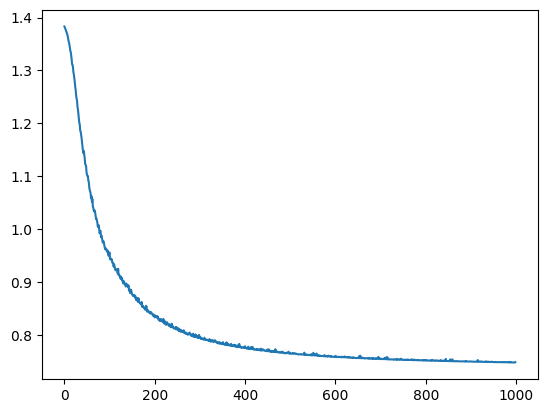

In [ ]:
# Just to check if the model converged nicely
import matplotlib.pyplot as plt
plt.plot(all_loss[1:epochs]);